# Final Project - Modeling.ipynb
Name: Bryce DiRisio

Class: CSCI349 - Intro to Data Mining

Semester: 2020sp

Instructor: Brian King

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
from sklearn import datasets, linear_model, tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier

from scipy import stats

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
#READING FUNCTION
df_raw = pd.read_csv('data\\wildlife_data_raw.csv')

#CLEANING FUNCTIONS (see DataPrep_EDA.ipynb for explanations on code)
df_raw.loc[:,'App.'] = df_raw.loc[:,'App.'].astype('category')
df_raw.loc[:,'Taxon'] = df_raw.loc[:,'Taxon'].astype('category')
df_raw.loc[:,'Importer'] = df_raw.loc[:,'Importer'].astype('category')
df_raw.loc[:,'Exporter'] = df_raw.loc[:,'Exporter'].astype('category')
df_raw.loc[:,'Origin'] = df_raw.loc[:,'Origin'].astype('category')
df_raw.loc[:,'Term'] = df_raw.loc[:,'Term'].astype('category')
df_raw.loc[:,'Unit'] = df_raw.loc[:,'Unit'].astype('category')
df_raw.loc[:,'Purpose'] = df_raw.loc[:,'Purpose'].astype('category')
df_raw.loc[:,'Source'] = df_raw.loc[:,'Source'].astype('category')
df_raw = df_raw.iloc[0:67007]
df_raw.iloc[:,7] = df_raw.iloc[:,7].cat.add_categories('0')
df_raw.iloc[:,7] = df_raw.iloc[:,7].fillna(value='0')
df_raw.iloc[:,8] = df_raw.iloc[:,8].cat.add_categories('0')
df_raw.iloc[:,8] = df_raw.iloc[:,8].fillna(value='0')
df_raw.iloc[:,15] = df_raw.iloc[:,15].cat.add_categories('0')
df_raw.iloc[:,15] = df_raw.iloc[:,15].fillna(value='0')
df_missing_imp_exp = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (df_raw.iloc[i,7]=='0' or df_raw.iloc[i,8]=='0')])
df_missing_source = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (df_raw.iloc[i,15]=='0')])
indices_ie = df_missing_imp_exp.index.values.tolist()
indices_s = df_missing_source.index.values.tolist()
indices = list(set().union(indices_ie,indices_s))
df_raw = df_raw.drop(indices)
df_raw = df_raw.reset_index(drop=True)
df_two_quantities = pd.DataFrame([df_raw.iloc[i] for i in range(df_raw.shape[0]) if (~np.isnan(df_raw.iloc[i,10]) and (~np.isnan(df_raw.iloc[i,11])))])
pd.DataFrame([df_two_quantities.iloc[i] for i in range(df_two_quantities.shape[0]) if df_two_quantities.iloc[i,10] != df_two_quantities.iloc[i,11]])
THRESHOLD = 4 #4x difference in two quantities
df_to_remove = pd.DataFrame([df_two_quantities.iloc[i] for i in range(df_two_quantities.shape[0]) if (df_two_quantities.iloc[i,11]/df_two_quantities.iloc[i,10] > THRESHOLD) or (df_two_quantities.iloc[i,10]/df_two_quantities.iloc[i,11] > THRESHOLD)])
df_to_remove
indices = df_to_remove.index.values.tolist()
df_raw = df_raw.drop(indices)
df_raw = df_raw.reset_index(drop=True)
df_raw['Quantity'] = 0

#fill in quantities
for i in range(df_raw.shape[0]):
    if np.isnan(df_raw.iloc[i,10]):
        df_raw.iloc[i,16] = df_raw.iloc[i,11]
    elif np.isnan(df_raw.iloc[i,11]):
        df_raw.iloc[i,16] = df_raw.iloc[i,10]
    else:
        df_raw.iloc[i,16] = (df_raw.iloc[i,10] + df_raw.iloc[i,11])/2
        
df_raw = df_raw.drop(labels = ['Importer reported quantity','Exporter reported quantity'],axis=1)
df_raw = df_raw.drop(labels = ['Class','Order','Family','Genus'],axis=1)
df_raw = df_raw.drop(labels = ['Origin','Year'],axis=1)
df_raw

App.                      Taxon Importer Exporter  \
0        I             Aquila heliaca       TR       NL   
1        I             Aquila heliaca       XV       RS   
2        I       Haliaeetus albicilla       BE       NO   
3        I       Haliaeetus albicilla       BE       NO   
4        I       Haliaeetus albicilla       DK       IS   
...    ...                        ...      ...      ...   
64896    N  Tribolonotus novaeguineae       DE       ID   
64897    N   Selaginella lepidophylla       DE       MX   
64898    N   Selaginella lepidophylla       DE       MX   
64899    N           Struthio camelus       RO       CH   
64900    N        Lamprotornis regius       DE       TZ   

                           Term Unit Purpose Source  Quantity  
0                        bodies  NaN       T      C       1.0  
1                        bodies  NaN       Q      O       1.0  
2                      feathers  NaN       S      W      43.0  
3                     specimens  NaN       S      W      43.0  
4                     specimens  NaN       S      W     700.0  
...                         ...  ...     ...    ...       ...  
64896                      live  NaN       T      U      20.0  
64897              dried plants   kg       T      W     162.3  
64898                    leaves   kg       T      W    5000.0  
64899  leather products (small)  NaN       T      C       1.0  
64900                      live  NaN       T      U      10.0  

[64901 rows x 9 columns]

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64901 entries, 0 to 64900
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   App.      64901 non-null  category
 1   Taxon     64901 non-null  category
 2   Importer  64901 non-null  category
 3   Exporter  64901 non-null  category
 4   Term      64901 non-null  category
 5   Unit      6153 non-null   category
 6   Purpose   59277 non-null  category
 7   Source    64901 non-null  category
 8   Quantity  64901 non-null  float64 
dtypes: category(8), float64(1)
memory usage: 1.6 MB


# First model idea: Apriori

## Apriori part 1 - Rules between import and export countries
Purpose: Find rules that may exist in relationships between importing and exporting countries

In [5]:
df_data = df_raw.iloc[:,2:4]
list_data = df_data.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(list_data).transform(list_data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

AD     AE     AF     AG     AI     AL     AM     AN     AO     AQ  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  False  False  False  False  False  False  False  False  False  False   
64897  False  False  False  False  False  False  False  False  False  False   
64898  False  False  False  False  False  False  False  False  False  False   
64899  False  False  False  False  False  False  False  False  False  False   
64900  False  False  False  False  False  False  False  False  False  False   

       ...     WS     XV     XX     YE     YT     YU     ZA     ZM     ZW  \
0      ...  False  False  False  False  False  False  False  False  False   
1      ...  False   True  False  False  False  False  False  False  False   
2      ...  False  False  False  False  False  False  False  False  False   
3      ...  False  False  False  False  False  False  False  False  False   
4      ...  False  False  False  False  False  False  False  False  False   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  ...  False  False  False  False  False  False  False  False  False   
64897  ...  False  False  False  False  False  False  False  False  False   
64898  ...  False  False  False  False  False  False  False  False  False   
64899  ...  False  False  False  False  False  False  False  False  False   
64900  ...  False  False  False  False  False  False  False  False  False   

          ZZ  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
64896  False  
64897  False  
64898  False  
64899  False  
64900  False  

[64901 rows x 234 columns]

In [6]:
display(df.describe())
df.info()

AD     AE     AF     AG     AI     AL     AM     AN     AO     AQ  \
count   64901  64901  64901  64901  64901  64901  64901  64901  64901  64901   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq    64854  62528  64807  64875  64900  64796  64742  64883  64845  64893   

        ...     WS     XV     XX     YE     YT     YU     ZA     ZM     ZW  \
count   ...  64901  64901  64901  64901  64901  64901  64901  64901  64901   
unique  ...      2      2      2      2      2      2      2      2      2   
top     ...  False  False  False  False  False  False  False  False  False   
freq    ...  64899  64870  64321  64893  64899  64896  63021  64769  64288   

           ZZ  
count   64901  
unique      2  
top     False  
freq    64875  

[4 rows x 234 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64901 entries, 0 to 64900
Columns: 234 entries, AD to ZZ
dtypes: bool(234)
memory usage: 14.5 MB


In [7]:
df_apriori = apriori(df,min_support=0.05,use_colnames=True)
df_apriori

support itemsets
0  0.060431     (CH)
1  0.053004     (CN)
2  0.113835     (DE)
3  0.092603     (FR)
4  0.050585     (HK)
5  0.102263     (ID)
6  0.092957     (IT)
7  0.093804     (JP)
8  0.121262     (NL)
9  0.212755     (US)

In [8]:
rules = association_rules(df_apriori, min_threshold = 0.00000005)
rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

It seems that supports are too low values in order to get meaningful pattern recognition with the apriori algorithm...

## Apriori part 2 - Patters between import countries and import items

In [9]:
df_data = df_raw.iloc[:,2:5]
df_data = df_data.drop('Exporter',axis=1)
list_data = df_data.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(list_data).transform(list_data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

AD     AE     AF     AG     AI     AL     AM     AN     AO     AR  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  False  False  False  False  False  False  False  False  False  False   
64897  False  False  False  False  False  False  False  False  False  False   
64898  False  False  False  False  False  False  False  False  False  False   
64899  False  False  False  False  False  False  False  False  False  False   
64900  False  False  False  False  False  False  False  False  False  False   

       ...  tails  teeth  timber  trophies  trunk  tusks  unspecified  veneer  \
0      ...  False  False   False     False  False  False        False   False   
1      ...  False  False   False     False  False  False        False   False   
2      ...  False  False   False     False  False  False        False   False   
3      ...  False  False   False     False  False  False        False   False   
4      ...  False  False   False     False  False  False        False   False   
...    ...    ...    ...     ...       ...    ...    ...          ...     ...   
64896  ...  False  False   False     False  False  False        False   False   
64897  ...  False  False   False     False  False  False        False   False   
64898  ...  False  False   False     False  False  False        False   False   
64899  ...  False  False   False     False  False  False        False   False   
64900  ...  False  False   False     False  False  False        False   False   

         wax  wood product  
0      False         False  
1      False         False  
2      False         False  
3      False         False  
4      False         False  
...      ...           ...  
64896  False         False  
64897  False         False  
64898  False         False  
64899  False         False  
64900  False         False  

[64901 rows x 297 columns]

In [10]:
df_apriori = apriori(df,min_support=0.05,use_colnames=True)
df_apriori

support                    itemsets
0  0.073728                        (DE)
1  0.078057                        (JP)
2  0.144435                        (US)
3  0.148180  (leather products (small))
4  0.512658                      (live)
5  0.056717                  (live, DE)
6  0.050770                  (live, JP)
7  0.054391                  (live, US)

In [11]:
rules = association_rules(df_apriori, min_threshold = 0.05)
rules.sort_values(['lift','confidence'],ascending = [False,False]).head(5)

antecedents consequents  antecedent support  consequent support   support  \
1        (DE)      (live)            0.073728            0.512658  0.056717   
0      (live)        (DE)            0.512658            0.073728  0.056717   
3        (JP)      (live)            0.078057            0.512658  0.050770   
2      (live)        (JP)            0.512658            0.078057  0.050770   
5        (US)      (live)            0.144435            0.512658  0.054391   

   confidence      lift  leverage  conviction  
1    0.769279  1.500570  0.018920    2.112258  
0    0.110634  1.500570  0.018920    1.041497  
3    0.650415  1.268711  0.010753    1.394058  
2    0.099032  1.268711  0.010753    1.023280  
5    0.376574  0.734551 -0.019655    0.781716

## Apriori part 3 - Export countries and transaction items

In [12]:
df_data = df_raw.iloc[:,2:5]
df_data = df_data.drop('Importer',axis=1)
list_data = df_data.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(list_data).transform(list_data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

AD     AE     AG     AL     AM     AN     AQ     AR     AT     AU  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
64896  False  False  False  False  False  False  False  False  False  False   
64897  False  False  False  False  False  False  False  False  False  False   
64898  False  False  False  False  False  False  False  False  False  False   
64899  False  False  False  False  False  False  False  False  False  False   
64900  False  False  False  False  False  False  False  False  False  False   

       ...  tails  teeth  timber  trophies  trunk  tusks  unspecified  veneer  \
0      ...  False  False   False     False  False  False        False   False   
1      ...  False  False   False     False  False  False        False   False   
2      ...  False  False   False     False  False  False        False   False   
3      ...  False  False   False     False  False  False        False   False   
4      ...  False  False   False     False  False  False        False   False   
...    ...    ...    ...     ...       ...    ...    ...          ...     ...   
64896  ...  False  False   False     False  False  False        False   False   
64897  ...  False  False   False     False  False  False        False   False   
64898  ...  False  False   False     False  False  False        False   False   
64899  ...  False  False   False     False  False  False        False   False   
64900  ...  False  False   False     False  False  False        False   False   

         wax  wood product  
0      False         False  
1      False         False  
2      False         False  
3      False         False  
4      False         False  
...      ...           ...  
64896  False         False  
64897  False         False  
64898  False         False  
64899  False         False  
64900  False         False  

[64901 rows x 290 columns]

In [13]:
df_apriori = apriori(df,min_support=0.05,use_colnames=True)
df_apriori

support                    itemsets
0  0.056039                        (FR)
1  0.096455                        (ID)
2  0.076701                        (IT)
3  0.110476                        (NL)
4  0.068319                        (US)
5  0.148180  (leather products (small))
6  0.512658                      (live)
7  0.077302                  (live, ID)
8  0.104498                  (live, NL)

In [14]:
rules = association_rules(df_apriori, min_threshold = 0.05)
rules.sort_values(['lift','confidence'],ascending = [False,False]).head(5)

antecedents consequents  antecedent support  consequent support   support  \
2      (live)        (NL)            0.512658            0.110476  0.104498   
3        (NL)      (live)            0.110476            0.512658  0.104498   
0      (live)        (ID)            0.512658            0.096455  0.077302   
1        (ID)      (live)            0.096455            0.512658  0.077302   

   confidence      lift  leverage  conviction  
2    0.203835  1.845063  0.047861    1.117261  
3    0.945886  1.845063  0.047861    9.005784  
0    0.150787  1.563300  0.027854    1.063980  
1    0.801438  1.563300  0.027854    2.454354

# Second model idea: Keras

Purpose: Try to see if we can estimate wildlife sources or wildlife items being traded given trade quantities

We can try to estimate source of wildlife (i.e. from wild or captivity), and we can try to estimate what items are being traded given quantities.

In [15]:
def model_performance():
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch Step')
    ax1.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

    #accuracy
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch Step')
    ax2.legend(['Train', 'Test'], loc='upper left')

    plt.show()

CATEGORICAL: TERM

In [16]:
X = df_raw.iloc[:,len(df_raw.columns)-1:] #numeric
y = df_raw.iloc[:,4] #categorical
X, y = shuffle(X, y)
X = stats.zscore(X)
y=pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=0)
y_train_binarized = pd.get_dummies(y_train)
y_test_binarized = pd.get_dummies(y_test)

In [17]:
def create_keras_term_model(activation, optimizer, hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(1,)))
    model.add(Activation(activation))
    model.add(Dense(83))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [18]:
param_grid = {
    'optimizer': ['adam','sgd'],
    'hidden_units': [5],
    'activation': ['relu','sigmoid'], #add tan
    'epochs': [10,20],
    'batch_size': [4]
}

grid = GridSearchCV(KerasClassifier(build_fn=create_keras_term_model, verbose=0),
                    param_grid,
                    return_train_score=True,
                    cv=5,
                    refit=False,
                    n_jobs = 4, pre_dispatch=4)

grid_result = grid.fit(X,y)

#get data
df_results = pd.DataFrame(grid_result.cv_results_)

def get_results(dataFrame):

    #set up columns
    df_params = dataFrame.loc[:,'params']
    df_mean_training = dataFrame.loc[:,'mean_train_score']
    df_mean_testing = dataFrame.loc[:,'mean_test_score']
    df_std_train = dataFrame.loc[:,'std_train_score']
    df_std_test = dataFrame.loc[:,'std_test_score']

    #form final table
    df_final = pd.DataFrame()
    df_final['params']=df_params
    df_final['mean_training']=df_mean_training
    df_final['std_training']=df_std_train
    df_final['mean_testing']=df_mean_testing
    df_final['std_testing']=df_std_test
    return df_final.sort_values(by='mean_testing',ascending=False).head(5)

get_results(df_results)

params  mean_training  \
1  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.512650   
4  {'activation': 'sigmoid', 'batch_size': 4, 'ep...       0.512658   
5  {'activation': 'sigmoid', 'batch_size': 4, 'ep...       0.512658   
6  {'activation': 'sigmoid', 'batch_size': 4, 'ep...       0.512658   
7  {'activation': 'sigmoid', 'batch_size': 4, 'ep...       0.512658   

   std_training  mean_testing  std_testing  
1      0.000669      0.512658     0.002678  
4      0.000670      0.512658     0.002678  
5      0.000670      0.512658     0.002678  
6      0.000670      0.512658     0.002678  
7      0.000670      0.512658     0.002678

Optimal model hyperparameters: 

In [19]:
get_results(df_results).iloc[0,0]

{'activation': 'relu',
 'batch_size': 4,
 'epochs': 10,
 'hidden_units': 5,
 'optimizer': 'sgd'}

In [20]:
model = create_keras_term_model(get_results(df_results).iloc[0,0]['activation'],get_results(df_results).iloc[0,0]['optimizer'],get_results(df_results).iloc[0,0]['hidden_units'])
history = model.fit(X_train, y_train_binarized, epochs=get_results(df_results).iloc[0,0]['epochs'], batch_size=get_results(df_results).iloc[0,0]['batch_size'], verbose=1, validation_data=(X_test, y_test_binarized))

Train on 32450 samples, validate on 32451 samples
Epoch 1/10
32450/32450 [==============================] - 9s 273us/step - loss: 2.4850 - accuracy: 0.5110 - val_loss: 2.2485 - val_accuracy: 0.5140
Epoch 2/10
32450/32450 [==============================] - 9s 285us/step - loss: 2.2323 - accuracy: 0.5113 - val_loss: 2.1910 - val_accuracy: 0.5140
Epoch 3/10
32450/32450 [==============================] - 9s 285us/step - loss: 2.1983 - accuracy: 0.5113 - val_loss: 2.1710 - val_accuracy: 0.5140
Epoch 4/10
32450/32450 [==============================] - 9s 289us/step - loss: 2.1839 - accuracy: 0.5113 - val_loss: 2.1616 - val_accuracy: 0.5140
Epoch 5/10
32450/32450 [==============================] - 9s 282us/step - loss: 2.1761 - accuracy: 0.5113 - val_loss: 2.1554 - val_accuracy: 0.5140
Epoch 6/10
32450/32450 [==============================] - 9s 283us/step - loss: 2.1712 - accuracy: 0.5113 - val_loss: 2.1512 - val_accuracy: 0.5140
Epoch 7/10
32450/32450 [==============================] - 11s 

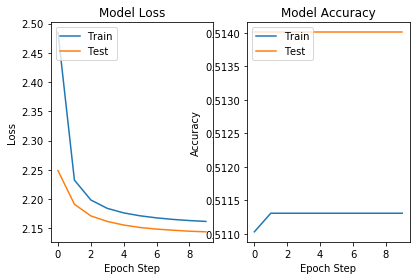

In [21]:
model_performance()